In [1]:
import pickle
import torch
import sys
sys.path.append('..')

import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import dist2prob, calibrate_fdr, predict, cal_ob_fdr

## 1. Load and preprocess data fromo PenLight2

In [2]:
seed = 0

_, train_dist, train_labels, train_idx2up, train_idx2ec = pickle.load(open(f'../example_data/train_{seed}.pkl', 'rb'))
_, cal_dist, cal_labels, cal_idx2prot, cal_idx2ec = pickle.load(open(f'../example_data/calib_{seed}.pkl', 'rb'))
_, test_dist, test_labels, test_idx2prot, test_idx2ec = pickle.load(open(f'../example_data/test_{seed}.pkl', 'rb'))
cal_labels = cal_labels.bool()
test_labels = test_labels.bool()

# transform distance values into probability values
cal_prob = dist2prob(train_dist, cal_dist)
test_prob = dist2prob(train_dist, test_dist)

print(f'Calibration set size: {cal_prob.shape[0]}')
print(f'Test set size: {test_prob.shape[0]}')

Calibration set size: 782
Test set size: 1837


## 2. Calibration: calibration set

In [3]:
alpha = 0.1 # FDR tolerance
delta = 0.1 # Significance value
N = 100 # total number of candidate model parameters

# acquire rejection set lambda_hats and final valid parameter lambda_hat
lambda_hats = calibrate_fdr(alpha, delta, cal_prob, cal_labels, N)
lambda_hat = lambda_hats[0]

print(f'FDR tolerance alpha: {alpha}')
print(f'Valid model parameter lambda: {lambda_hat}')

FDR tolerance alpha: 0.1
Valid model parameter lambda: 0.8787878751754761


## 3. Prediction: test set

In [4]:
observed_fdr, precision, recall, ndcg, df = predict(test_prob, test_labels, lambda_hat, test_idx2prot, test_idx2ec)
print(f'Observed FDR: {observed_fdr:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'nDCG: {ndcg:.4f}')

Observed FDR: 0.0455
Precision: 0.9545
Recall: 0.4932
nDCG: 0.5702


In [5]:
# An example of prediction sets
df

,PDB-chain,Ground truth,CPEC prediction
0,2FOR-A,[2.5.1.10],"[2.5.1.10, 2.5.1.1]"
1,5U4N-A,[4.1.2.13],[4.1.2.13]
2,1NW6-A,[2.1.1.72],[]
3,2AAK-A,[2.3.2.23],"[2.3.2.23, 2.3.2.24]"
4,4S1N-A,[2.1.2.2],[2.1.2.2]
...,...,...,...
1832,1VKE-A,[1.11.1.15],"[1.11.1.24, 1.11.1.15]"
1833,1T5I-A,[3.6.4.13],[]
1834,1JWE-A,[3.6.4.12],[]
1835,3ZH3-A,[2.5.1.7],[2.5.1.7]


# 4. Visualization

In [6]:
df['Observed FDR'] = df.apply(lambda row: cal_ob_fdr(row['Ground truth'], row['CPEC prediction']), axis=1)
df['Observed FDR'].mean()

0.04553380275585597

/work/kerr/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


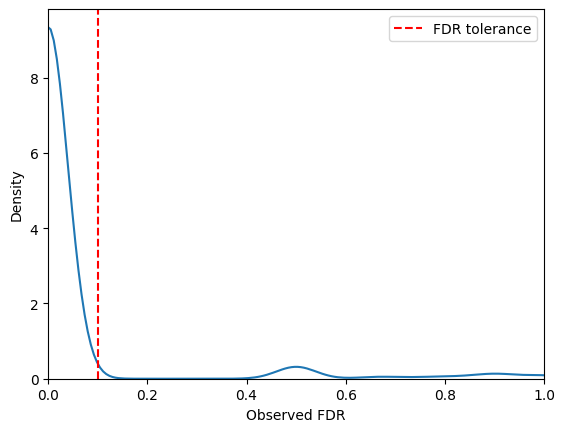

In [7]:
fig, ax = plt.subplots(1, 1)

sns.kdeplot(ax=ax, data=df, x='Observed FDR')
ax.set_xlim([0,1])
ax.axvline(x=alpha, color='r', linestyle='--', label='FDR tolerance')
ax.legend()

plt.show()